# Solving ODE & PDE with Artificial Neural Networks

Two versions will be applied, as followed:

- Tensorflow version
- PyTorch version

and this note is a __Tensorflow__ version.

_Reference https://github.com/Rachnog/Neural-Networks-for-Differential-Equations_


## I. A First-Order ODE

The following equation will be solved with a ANN:

$$
\begin{cases}
\dfrac{{\rm d}\psi}{{\rm d}x}+(x+\dfrac{1+3x^2}{1+x+x^3})\psi=x^3+2x+x^2\cdot\dfrac{1+3x^2}{1+x+x^3}, \\[2ex]
\psi(0)=1, \\[1ex]
x \in [0,1]. \tag 1
\end{cases}
$$

Its analytical solution is 

$$
\psi(x)=\dfrac{{\rm e}^{-\frac{x^2}{2}}}{1+x+x^3}+x^2.\tag 2
$$

Suppose that the trial solution to the ODE is 

$$
\psi_t(x, p)=A(x)+F(x, N(x, p)).\tag 3
$$

In (3), $ A(\cdot) $ satisfies initial conditions (IC) and boundary conditions (BC), $ F(\cdot,\cdot) $ doesn't do with IC or BC, $ N(\cdot,\cdot) $ is a ANN and $ p $ means parameters of it.

According to IC in (1), it can be known $ A=1 $ and $ F(x, N(x, p)) = xN(x, p) $. Exactly, it means 

$$
\psi_t(x, p)=1+xN(x, p).\tag 4
$$

Now set up $ N=10 $ points ($ x_1=0,x_2=0.11,...,x_{10}=1 $) as benchmark. Meanwhile, let

$$
f(x, \psi)=x^3+2x+x^2\cdot\dfrac{1+3x^2}{1+x+x^3}-(x+\dfrac{1+3x^2}{1+x+x^3})\psi.\tag 5
$$

So the loss function is 

$$
L(x_1,...,x_N,p)=\dfrac{1}{2}\sum_{i=1}^N[\dfrac{{\rm d}\psi_t}{{\rm d}x}|_{x=x_i}-f(x_i,\psi_t(x_i,p))]^2.\tag 6
$$

Well, just use a single hidden layer, ten neurons and set sigmoid as the activation function. Then with gradient descending and back propagation, $ N(\cdot,\cdot) $ can be obtained.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

In [12]:
def analytical_sol(x):
    return x**2 + np.exp(-x**2/2) / (1+x+x**3)


def f(x, psi):
    right_hand = x**3 + 2*x + x**2 * ((1+3*x**2)/(1+x+x**3))
    left_hand = (x + (1+3*x**2)/(1+x+x**3)) * psi
    return right_hand - left_hand


def A(x):
    return 1


def N(x, params):
    weight = params[0]
    bias = params[1]
    for i in range(len(weight)):    # len(weight) means the number of layers (hidden + output)
        w_i = weight[i]
        b_i = bias[i]
        hidden_layer_i = tf.add(tf.matmul(w_i, x), b_i)
        if i != len(weight)-1:
            x = tf.sigmoid(hidden_layer_i)    # activation function
        else:
            x = hidden_layer_i
            
    return x


def psi_t(x, params):
    F = x * N(x, params)
    return A(x) + F


def loss_function(x_inputs, params):
    loss = 0
    for x_i in x_inputs:
        psi_t_val = psi_t(x_i, params)
        psi_t_dx = tf.gradients(psi_t_val, x_i)    # return a list
        loss += 0.5 * (psi_t_dx[0]-f(x_i, psi_t_val))**2
    
    return loss


def training_op(x_inputs, params, learning_rate=0.01):
    loss = loss_function(x_inputs, params)
    opt = tf.train.AdamOptimizer(learning_rate)
    return opt.minimize(loss, var_list=params)

In [17]:
x1_10 = np.linspace(0, 1, 10)
y1_10 = analytical_sol(x1_10)
psi1_10 = []

lr = 0.001    # learning rate
n_iter = 1500    # number of iterations
n_neurons = 10

W1 = tf.Variable(tf.truncated_normal(shape=[n_neurons, 1]))
W2 = tf.Variable(tf.truncated_normal(shape=[1, n_neurons]))
b1 = tf.Variable(tf.zeros(shape=[n_neurons, 1]) + 0.1)
b2 = tf.Variable(0.1)

X_inputs = [tf.constant(x_i, shape=[1, 1], dtype=tf.float32) for x_i in x1_10]
Params = [[W1, W2], [b1, b2]]
trainOp = training_op(X_inputs, Params, learning_rate=lr)

init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(n_iter):
        sess.run(trainOp)
    
    for X_i in X_inputs:
        psi1_10.append(sess.run(psi_t(X_i, Params)).reshape((1,)))

Now we get ANN's solution values on ten points ("psi1_10"). They will be compared with those of the analytical solution ("y1_10").

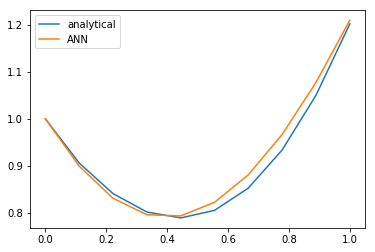

In [18]:
plt.plot(x1_10, y1_10, label='analytical')
plt.plot(x1_10, psi1_10, label='ANN')
plt.legend()
plt.show()

The result is great. Detailed parameters setting is followed:

- 1 hidden layer with 10 neurons;
- learning_rate = 0.001;
- n_iteration = 1500;
- 10 points as a sample;

However, there is still some problem: Tensorflow is not stable, the convergence may be very slow.

## II. A Second-Order ODE

The following second-order equation will be solved by ANN:

$$
\begin{cases}
\dfrac{{\rm d^2}\psi}{{\rm d}x^2}+\dfrac{1}{5}\dfrac{{\rm d}\psi}{{\rm d}x}+\psi=-\dfrac{1}{5}{\rm e}^{-\frac{x}{5}}\cos x, \\[2ex]
\psi(0)=1, \\[1ex]
\psi(1)={\rm e}^{-\frac{1}{5}}\sin 1, \\[1ex]
x \in [0,2]. \tag 7
\end{cases}
$$

Its analytical solution is 

$$
\psi(x)={\rm e}^{-\frac{x}{5}}\sin x.\tag 8
$$

According to BC in (7), it can be supposed that 

$$
\psi_t(x, p)=A(1-x)+Bx+x(1-x)N(x,p)=x{\rm e}^{-\frac{1}{5}}\sin 1 + x(1-x)N(x,p).\tag 9
$$

Now divide $ [0,2] $ into ten equal parts, noted as $ x_1,...,x_{10} $. Meanwhile, let

$$
f(x,\psi,\dfrac{{\rm d}\psi}{{\rm d}x})=-\dfrac{1}{5}{\rm e}^{-\frac{x}{5}}\cos x
-\dfrac{1}{5}\dfrac{{\rm d}\psi}{{\rm d}x}-\psi.\tag{10}
$$

And set the loss function as followed: 

$$
L(x_1,...,x_{10},p)=
\dfrac{1}{2}\sum_{i=1}^{10}[\dfrac{{\rm d^2}\psi_t}{{\rm d}x^2}|_{x=x_i}
-f(x_i,\psi_t,\dfrac{{\rm d}\psi_t}{{\rm d}x})]^2.\tag{11}
$$

As is mentioned in the first section, use a single hidden layer, ten neurons and set sigmoid as the activation function. Then with gradient descending and back propagation, $ N(\cdot,\cdot) $ can be obtained.

In [9]:
def analytical_sol(x):
    return np.exp(-x/5) * np.sin(x)


def f(x, psi, dpsi):
    right_hand = -.2 * tf.exp(-x/5) * tf.cos(x)
#     print(len(dpsi))
    left_hand = psi + .2 * dpsi
    return right_hand - left_hand


def A(x):
    return x * np.sin(1) * np.exp(-.2)


def N(x, params):
    weight = params[0]
    bias = params[1]
    for i in range(len(weight)):    # len(weight) means the number of layers (hidden + output)
        w_i = weight[i]
        b_i = bias[i]
        hidden_layer_i = tf.add(tf.matmul(w_i, x), b_i)
        if i != len(weight)-1:
            x = tf.sigmoid(hidden_layer_i)    # activation function
        else:
            x = hidden_layer_i
            
    return x


def psi_t(x, params):
    F = x * (1 - x) * N(x, params)
    return A(x) + F


def loss_function(x_inputs, params):
    loss = 0
    for x_i in x_inputs:
        psi_t_val = psi_t(x_i, params)
        psi_t_dx = tf.gradients(psi_t_val, x_i)
        psi_t_dx2 = tf.gradients(psi_t_dx, x_i)
        loss += 0.5 * (psi_t_dx2[0]-f(x_i, psi_t_val, psi_t_dx[0]))**2
    
    return loss


def training_op(x_inputs, params, learning_rate=0.01):
    loss = loss_function(x_inputs, params)
    opt = tf.train.AdamOptimizer(learning_rate)
    return opt.minimize(loss, var_list=params)

In [10]:
x1_10 = np.linspace(0, 2, 10)
y1_10 = analytical_sol(x1_10)
psi1_10 = []

lr = 0.001    # learning rate
n_iter = 100    # number of iterations
n_neurons = 10

W1 = tf.Variable(tf.truncated_normal(shape=[n_neurons, 1]))
W2 = tf.Variable(tf.truncated_normal(shape=[1, n_neurons]))
b1 = tf.Variable(tf.zeros(shape=[n_neurons, 1]) + 0.1)
b2 = tf.Variable(0.1)

X_inputs = [tf.constant(x_i, shape=[1, 1], dtype=tf.float32) for x_i in x1_10]
Params = [[W1, W2], [b1, b2]]
trainOp = training_op(X_inputs, Params, learning_rate=lr)

init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(n_iter):
        sess.run(trainOp)
    
    for X_i in X_inputs:
        psi1_10.append(sess.run(psi_t(X_i, Params)).reshape((1,)))

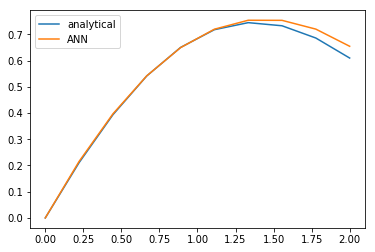

In [11]:
plt.plot(x1_10, y1_10, label='analytical')
plt.plot(x1_10, psi1_10, label='ANN')
plt.legend()
plt.show()

The result is also great. Detailed parameters setting is followed:

- 1 hidden layer with 10 neurons;
- learning_rate = 0.001;
- n_iteration = 100;
- 10 points as a sample;

## III. A PDE

Now a PDE below will be solved with a ANN:

$$
\begin{cases}
\nabla^2\psi=\dfrac{\partial^2}{\partial x_1^2}\psi+\dfrac{\partial^2}{\partial x_2^2}\psi=0, \\[1ex]
\psi(x)=0, & \forall x \in \{(x_1,x_2)\notin\partial D\, |\, x_1=0\, or\,x_1=1\, or\, x_2=0\} \\[1ex]
\psi(x)=\sin\pi x_1, & \forall x \in \{(x_1,x_2)\in\partial D\, |\, x_2=1\} \\[1ex]
D=[0,1]\times[0,1]. \tag{12}
\end{cases}
$$

Its analytical solution is 

$$
\psi(x)=\dfrac{1}{{\rm e}^\pi-{\rm e}^{-\pi}}\sin{\pi x_1}({\rm e}^{\pi x_2}-{\rm e}^{-\pi x_2}).\tag{13}\\[1ex]
$$

Suppose that the trial solution to (12) is 

$$
\psi_t(x_1,x_2,p)=A(x_1,x_2)+F(x_1,x_2,N(x_1,x_2,p)).\tag{14}
$$

In (14), $ A(\cdot) $ satisfies BCs in (12), $ F(\cdot) $ doesn't do with them. So it can be known 

$$
\psi_t(x_1,x_2,p)=x_2 \sin{\pi x_1}+x_1(1-x_1)x_2(1-x_2)N(x_1,x_2,p).\tag{15}
$$

Now set up $ N=10 $ points $ x^{(1)},x^{(2)},...,x^{(10)} $ as benchmark. Because $ f(x_1,x_2)=0 $, so the loss function is 

$$
L(x^{(1)},...,x^{(10)},p)=\dfrac{1}{2}\sum_{i=1}^{10}(\nabla^2 \psi|_{x=x^{(i)}})^2.\tag{16}
$$


In [41]:
def analytical_sol(x):
    return 1/(np.exp(np.pi)-np.exp(-np.pi)) * np.sin(np.pi*x[0]) * (np.exp(np.pi*x[1])-np.exp(-np.pi*x[1]))


def f(x):
    return 0


def A(x):
    return x[1] * tf.sin(np.pi*x[0])


def N(x, params):
    weight = params[0]
    bias = params[1]
    for i in range(len(weight)):    # len(weight) means the number of layers (hidden + output)
        w_i = weight[i]
        b_i = bias[i]
        hidden_layer_i = tf.add(tf.matmul(w_i, x), b_i)
        if i != len(weight)-1:
            x = tf.sigmoid(hidden_layer_i)    # activation function
        else:
            x = hidden_layer_i
            
    return x


def psi_t(x, params):
    F = x[0] * (1-x[0]) * x[1] * (1-x[1]) * N(x, params)
    return A(x) + F

In [49]:
def loss_function(x_inputs, params):
    loss = 0
    for x_i in x_inputs:
        psi_t_val = psi_t(x_i, params)
        psi_t_hess = tf.hessians(psi_t_val, x_i)[0]
        loss += 0.5 * (psi_t_hess[0][0][0] + psi_t_hess[1][0][1])**2
#         psi_t_dx1 = tf.gradients(psi_t_val, x_i)[0]
#         psi_t_dx11 = tf.gradients(psi_t_dx1[0], x_i)[0][0]
#         psi_t_dx22 = tf.gradients(psi_t_dx1[1], x_i)[0][1]        
#         loss += 0.5 * (psi_t_dx11 + psi_t_dx22)**2
    
    return loss

In [ ]:
lr = 0.001    # learning rate
n_iter = 100    # number of iterations
n_neurons = 10

W1 = tf.Variable(tf.truncated_normal(shape=[n_neurons, 2]))
W2 = tf.Variable(tf.truncated_normal(shape=[1, n_neurons]))
b1 = tf.Variable(tf.zeros(shape=[n_neurons, 1]) + 0.1)
b2 = tf.Variable(0.1)

X = np.mgrid[0:1:1/9,0:1:1/9].reshape((2,-1)).T
X_inputs = [tf.constant(Xi, shape=[2, 1], dtype=tf.float32) for Xi in X]
Params = [[W1, W2], [b1, b2]]
Psi = []

loss = loss_function(X_inputs, Params)
opt = tf.train.AdamOptimizer(lr)
training_op = opt.minimize(loss, var_list=Params)

init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(n_iter):
        sess.run(trainOp)
    
#     for X_i in X_inputs:
#         Psi.append(sess.run(psi_t(X_i, Params)).reshape((1,)))

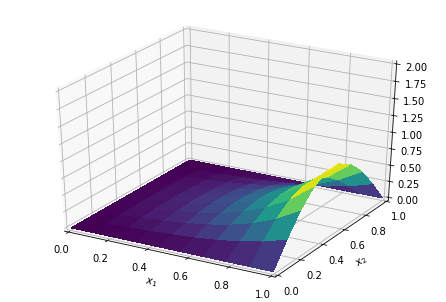

In [33]:
fig = plt.figure()
ax = Axes3D(fig)
x1_space = np.linspace(0,1,10)
x2_space = np.linspace(0,1,10)

X1, X2 = np.meshgrid(x1_space, x2_space)
Y = np.zeros((10,10))

for i, x1 in enumerate(x1_space):
    for j, x2 in enumerate(x2_space):
        Y[i][j] = analytical_sol([x1, x2])

ax.plot_surface(X1, X2, Y, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False);

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 2)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

The construction of loss function wastes lots of time, so the results cannot be got.

Detailed parameters setting is followed:

- 1 hidden layer with 10 neurons;
- learning_rate = 0.001;
- n_iteration = 100;
- 10$\times$10 points as a sample;